# Red Queen Observation

## Imports

In [1]:
import sys
import os
import os.path
import io
import csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import gamma
from scipy import integrate
import seaborn as sns
import numpy.random as nprand
from scipy.stats import gamma

## Read file

In [2]:
def readfiles(pathtofile, file_name, ext_name,withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin):
    data_file = pathtofile+file_name+"."+ext_name
    data = dict()
    params = []
    nbline=1
    with io.open(data_file,'r') as f:
        reader = csv.reader(f)
        firstline = True
        for line in reader:
            lin = line[0].split()
            if not firstline:
                if nbline>=line_to_begin:
                    for j in range(len(lin)):
                        if ext_name == "allele":
                            if float(lin[5])>minq and float(lin[6])>minfert:
                                if withoutneutral==1 and float(lin[1]) != -3 :
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j])) 
                                elif withoutneutral==0:
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j]))
                        elif ext_name == "trace" and logfert==True and (j==6 or j==14):
                            data[params[j]].append(np.log(float(lin[j])))
                        else :
                            data[params[j]].append(float(lin[j]))
                nbline=nbline+1
            else:
                for j in lin:
                    data[j]=[]
                    params.append(j)
                firstline = False
                nbline=nbline+1
    return (data)

## Functions for plot

In [3]:
def graph_per_allele(target_folder_path, file_name, ext_name, x_axis_param, y_axis_param,withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin):
    data_all = readfiles(target_folder_path, file_name, 'allele',withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin)
    data_trace = readfiles(target_folder_path, file_name, 'trace',withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin)
    x_per_allele=dict()
    y_per_allele=dict()
    for i in range(len(data_all["Generation_number"])):
        cle = data_all['Allele_number'][i]
        if ((str(cle) in x_per_allele) == False and cle!=-3):
            x_per_allele[str(cle)]=[]
            x_per_allele[str(cle)].append(data_all[x_axis_param][i])
            y_per_allele[str(cle)]=[]
            if y_axis_param=="selection":
                sel_coef=np.log(data_all['fertility_analytic'][i])-np.log(data_trace['fertility_analytic'][int(data_all["Generation_number"][i]/100)])
                y_per_allele[str(cle)].append(sel_coef)
            else:
                y_per_allele[str(cle)].append(data_all[y_axis_param][i])
        elif ((str(cle) in x_per_allele) == True and cle!=-3):
            x_per_allele[str(cle)].append(data_all[x_axis_param][i])
            if y_axis_param=="selection":
                sel_coef=np.log(data_all['fertility_analytic'][i])-np.log(data_trace['fertility_analytic'][int(data_all["Generation_number"][i]/100)])
                y_per_allele[str(cle)].append(sel_coef)
            else:
                y_per_allele[str(cle)].append(data_all[y_axis_param][i])
    return(x_per_allele,y_per_allele)

In [4]:
def plot_regim_per_allele(target_folder_path, file_name, ext_name, x_param, y_params, withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,legend_list,ymin,ymax):
    index_line=1
    lettres=["A","B","C","D","E"]
    figure=plt.figure(figsize=(8,10))
    figure.patch.set_facecolor('white')
    figure.patch.set_alpha(0)
    for i in y_params:
        max_y=0
        plt.subplot(len(y_params),1,index_line) 
        (X,Y)=graph_per_allele(target_folder_path, file_name, ext_name, x_param, i, withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin)
        for j in range(allelenbmax-allelenbmin):
            allele_nb=allelenbmin+j
            nameallelelist=[str(allele_nb),'.0']
            nameallele=''.join(nameallelelist)
            if X.get(nameallele, 0)!=0:
                if(float(nameallele)==boldallel):
                    plt.plot(X[nameallele], Y[nameallele],linewidth=6)
                else:
                    plt.plot(X[nameallele], Y[nameallele])
                if(max_y<max(Y[nameallele])):
                    max_y=max(Y[nameallele])
        plt.plot(X[str(boldallel)+'.0'], Y[str(boldallel)+'.0'],linewidth=6,color='darkred')
        plt.ylabel(legend_list[index_line-1],fontsize=11)
        plt.text(x=x_letter,y=max_y,s=lettres[index_line-1],fontweight='bold',fontsize=16)
        if index_line==len(y_params):
            plt.xlabel("Number of generations",fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        if i=="selection":
            plt.axhline(y=0, color='black')
        plt.xlim(xmin,xmax)
        if ymin!=[] and ymax!=[]:
            plt.ylim(ymin[index_line-1],ymax[index_line-1])
        index_line+=1

In [5]:
path_to_file_init = "../../../analyses/"

## Monomorphic regime

### Parameters for the plot

In [26]:
u="5e-6"
v="5e-5"
path_to_file_to_plot = "scaling_bidim_U_V/scaling_bidim_1/scaling_V_"+v+"/"
file_to_plot = "Run_U_"+u
ext_of_file = "allele"
x_parameter = "Generation_number"
y_parameters = ["Frequency","Activity","mean_affinity","q_analytic","fertility_analytic"]
withoutneutral = 0
withoutnan = 0
minq = 0
minfert = 0
logfert = 0
line_to_begin = 413
allelenbmin = 500
allelenbmax = 2000
boldallel = 1232
xmin = 12000
xmax = 38000
x_letter = 7000
ymin=[]
ymax=[]
legend_list=["Frequency of\n PRDM9 alleles","Proportion of\n active sites","Mean affinity\n of active sites\n per allele","Symmetrical binding\n probability","Fertility of\n PRDM9 alleles"]

### Graphic

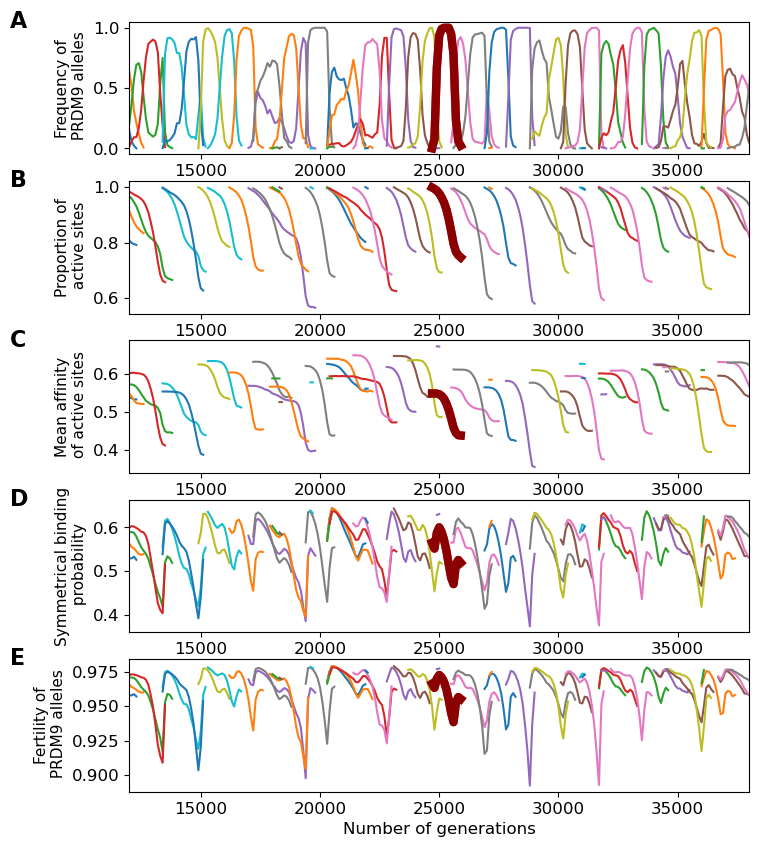

In [27]:
fig1=plot_regim_per_allele(path_to_file_init+path_to_file_to_plot, file_to_plot, ext_of_file, x_parameter,y_parameters,withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,legend_list)
plt.savefig('Fig_1.png', dpi=200, bbox_inches='tight') #, transparent = True

**Caption : PRDM9 dynamic : example of a monomorphic regime (u = 5e−6 and v = 5e−5).** In
all the graphs, each color corresponds to a different allele. Note that a given color can be reasigned to a
new allele later in the simulation. This figure represents the evolution along time of (A) the frequency of
each PRDM9 allele and their corresponding (B) proportion of active sites, (C) mean affinity, (D)
probability of symmetrical binding and (E) fertility. The bold trajectory represent a typical allele trajectory

## Polymorphic regime

### Parameters for the plot

In [59]:
u="5e-4"
v="5e-5"
path_to_file_to_plot = "scaling_bidim_U_V/scaling_bidim_1/scaling_V_"+v+"/"
file_to_plot = "Run_U_"+u
ext_of_file = "allele"
x_parameter = "Generation_number"
y_parameters = ["Frequency","Activity","mean_affinity","q_analytic","fertility_analytic"]
withoutneutral = 0
withoutnan = 0
minq = 0
minfert = 0
logfert = 0
line_to_begin = 14550
allelenbmin = 100017
allelenbmax = 159418
boldallel = 125789
xmin = 22000
xmax = 32000
x_letter = 20000
ymin=[]
ymax=[]
legend_list=["Frequency of\n PRDM9 alleles","Proportion of\n active sites","Mean affinity\n of active sites","Symmetrical binding\n probability","Fertility of\n PRDM9 alleles"]

### Graphic

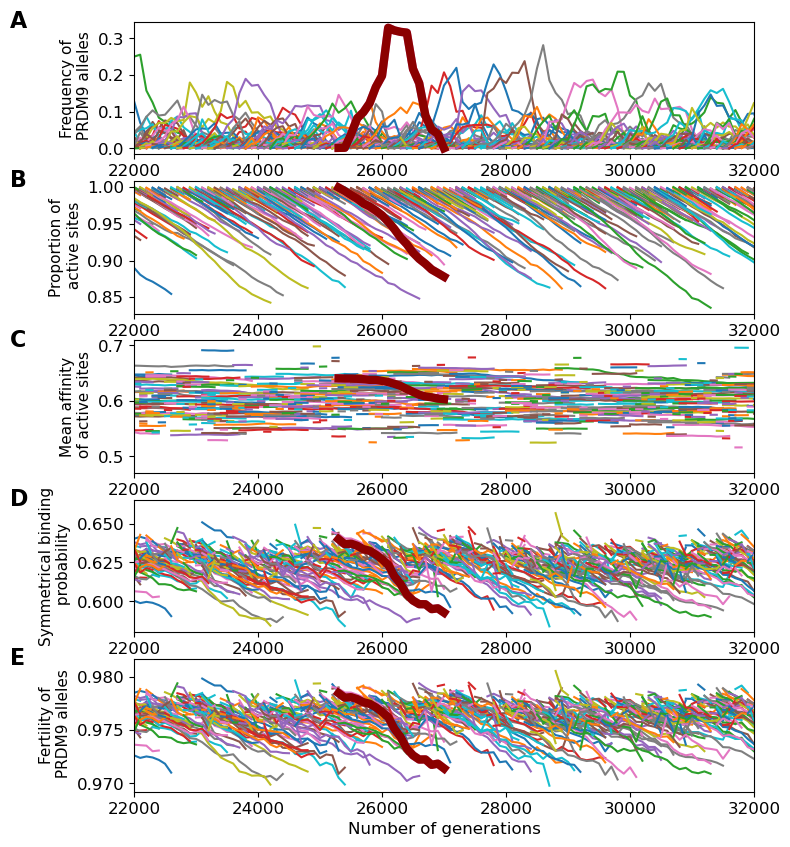

In [60]:
Fig_2=plot_regim_per_allele(path_to_file_init+path_to_file_to_plot, file_to_plot, ext_of_file, x_parameter,y_parameters,withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,legend_list,ymin,ymax)
plt.savefig('Fig_2.png', dpi=300, bbox_inches='tight')

**Caption : PRDM9 dynamic : example of a polymorphic regime (u = 5e−4 and v = 5e−5).** In
all the graphs, each color corresponds to a different allele. Note that a given color can be reassigned to a
new allele later in the simulation. This figure represents the evolution along time of (A) the frequency of
each PRDM9 allele and their corresponding (B) proportion of active sites, (C) mean affinity, (D)
probability of symmetrical binding and (E) fertility. The bold trajectory represent a typical allele trajectory
that escaped from genetic drift.